<a href="https://colab.research.google.com/github/kridtapon/Silent-Skyrocket/blob/main/Silent_Skyrocket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.1 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# --- Helper: Ease of Movement (EOM) ---
def calculate_eom(df, period=14):
    box_ratio = (df['High'] - df['Low']) / df['Volume']
    dm = ((df['High'] + df['Low']) / 2) - ((df['High'].shift(1) + df['Low'].shift(1)) / 2)
    eom = (dm * (df['High'] - df['Low'])) / (df['Volume'] / 100_000)
    eom = eom.rolling(period).mean()
    return eom

# --- Helper: Aroon Indicator ---
def calculate_aroon(df, period=25):
    aroon_up = df['High'].rolling(window=period + 1).apply(lambda x: 100 * (period - x[::-1].argmax()) / period, raw=True)
    aroon_down = df['Low'].rolling(window=period + 1).apply(lambda x: 100 * (period - x[::-1].argmin()) / period, raw=True)
    return aroon_up, aroon_down

# Load historical data
symbol = 'TPR'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# Calculate indicators
df['EOM'] = calculate_eom(df, period=14)
df['Aroon_Up'], df['Aroon_Down'] = calculate_aroon(df, period=25)

# Entry condition:
df['EOM_Rising'] = df['EOM'] > df['EOM'].shift(5)
df['Entry'] = (
    (df['EOM'] > 0) &
    (df['EOM_Rising']) &
    (df['Aroon_Down'] < 30)
)

# Exit condition:
# - Aroon_Up drops below 50
df['Exit'] = df['Aroon_Up'] < 50

# Filter test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift signals to avoid lookahead bias
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# Run portfolio
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],  # Execute at next open
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Display results
print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  353758.145096
Total Return [%]                              253.758145
Benchmark Return [%]                          174.557006
Max Gross Exposure [%]                             100.0
Total Fees Paid                              6936.307278
Max Drawdown [%]                               22.647177
Max Drawdown Duration                  431 days 00:00:00
Total Trades                                          20
Total Closed Trades                                   19
Total Open Trades                                      1
Open Trade PnL                               81943.94437
Win Rate [%]                                   63.157895
Best Trade [%]                                 56.049206
Worst Trade [%]                

[*********************100%***********************]  1 of 1 completed


Best Parameters:
EOM Period: 15, Aroon Period: 29, EOM Rising Shift: 9
Final Portfolio Value: $457,044.99


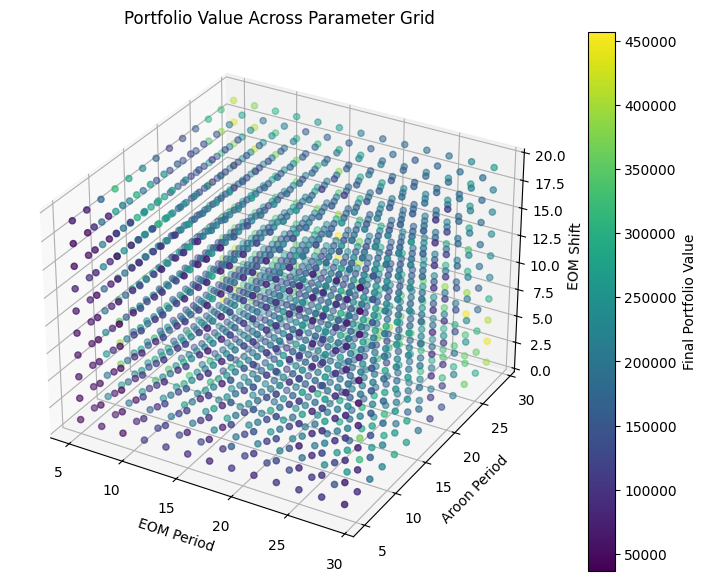

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# --- Helper: Ease of Movement (EOM) ---
def calculate_eom(df, period):
    dm = ((df['High'] + df['Low']) / 2) - ((df['High'].shift(1) + df['Low'].shift(1)) / 2)
    eom = (dm * (df['High'] - df['Low'])) / (df['Volume'] / 100_000)
    return eom.rolling(period).mean()

# --- Helper: Aroon Indicator ---
def calculate_aroon(df, period):
    aroon_up = df['High'].rolling(window=period + 1).apply(
        lambda x: 100 * (period - x[::-1].argmax()) / period, raw=True)
    aroon_down = df['Low'].rolling(window=period + 1).apply(
        lambda x: 100 * (period - x[::-1].argmin()) / period, raw=True)
    return aroon_up, aroon_down

# --- Load Data ---
symbol = 'TPR'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# --- Optimization Grid ---
eom_periods = range(5, 31, 2)
aroon_periods = range(5, 31, 2)
eom_rising_shifts = range(1, 21, 2)

results = []

for eom_p, aroon_p, eom_shift in product(eom_periods, aroon_periods, eom_rising_shifts):
    temp_df = df.copy()

    temp_df['EOM'] = calculate_eom(temp_df, period=eom_p)
    temp_df['Aroon_Up'], temp_df['Aroon_Down'] = calculate_aroon(temp_df, period=aroon_p)

    temp_df['EOM_Rising'] = temp_df['EOM'] > temp_df['EOM'].shift(eom_shift)
    temp_df['Entry'] = (
        (temp_df['EOM'] > 0) &
        (temp_df['EOM_Rising']) &
        (temp_df['Aroon_Down'] < 30)
    )
    temp_df['Exit'] = temp_df['Aroon_Up'] < 50
    df_test = temp_df[(temp_df.index.year >= 2020) & (temp_df.index.year <= 2025)]

    shifted_entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
    shifted_exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

    portfolio = vbt.Portfolio.from_signals(
        close=df_test['Open'],
        entries=shifted_entries,
        exits=shifted_exits,
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )

    final_value = portfolio.final_value()  # <- FIXED
    results.append((final_value, eom_p, aroon_p, eom_shift))

# --- Get Best Result ---
best_result = max(results, key=lambda x: x[0])
best_value, best_eom_p, best_aroon_p, best_shift = best_result

print(f"Best Parameters:\nEOM Period: {best_eom_p}, Aroon Period: {best_aroon_p}, EOM Rising Shift: {best_shift}")
print(f"Final Portfolio Value: ${best_value:,.2f}")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Unpack Results ---
final_values = [r[0] for r in results]
eom_ps = [r[1] for r in results]
aroon_ps = [r[2] for r in results]
shifts = [r[3] for r in results]

# --- Plot 3D Surface ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(eom_ps, aroon_ps, shifts, c=final_values, cmap='viridis', s=20)

ax.set_xlabel('EOM Period')
ax.set_ylabel('Aroon Period')
ax.set_zlabel('EOM Shift')
ax.set_title('Portfolio Value Across Parameter Grid')
fig.colorbar(sc, ax=ax, label='Final Portfolio Value')

plt.show()


In [15]:
# Calculate indicators
df['EOM'] = calculate_eom(df, period=15)
df['Aroon_Up'], df['Aroon_Down'] = calculate_aroon(df, period=29)

# Entry condition:
df['EOM_Rising'] = df['EOM'] > df['EOM'].shift(9)
df['Entry'] = (
    (df['EOM'] > 0) &
    (df['EOM_Rising']) &
    (df['Aroon_Down'] < 30)
)

# Exit condition:
# - Aroon_Up drops below 50
df['Exit'] = df['Aroon_Up'] < 50

# Filter test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift signals to avoid lookahead bias
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# Run portfolio
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],  # Execute at next open
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Display results
print(portfolio.stats())
portfolio.plot().show()

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           457044.985522
Total Return [%]                       357.044986
Benchmark Return [%]                   174.557006
Max Gross Exposure [%]                      100.0
Total Fees Paid                       6234.381257
Max Drawdown [%]                        31.500304
Max Drawdown Duration           420 days 00:00:00
Total Trades                                   16
Total Closed Trades                            15
Total Open Trades                               1
Open Trade PnL                      105869.135135
Win Rate [%]                            66.666667
Best Trade [%]                          88.681121
Worst Trade [%]                        -12.388225
Avg Winning Trade [%]                   19.187531
Avg Losing Trade [%]                    -6.583753
